In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

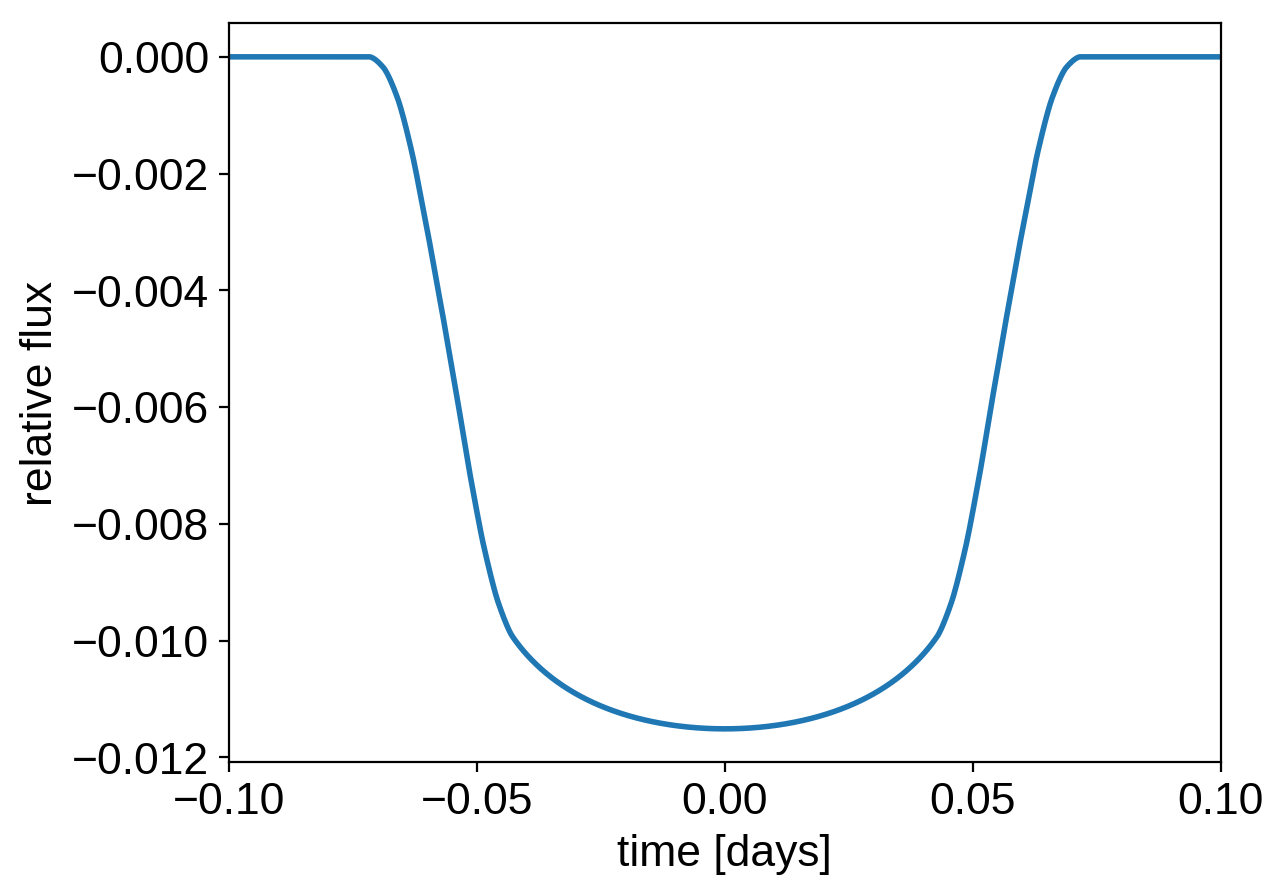

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.LimbDarkLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06]))
    b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))
        
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 191.36it/s, logp=2.478798e+04]

2it [00:00, 276.71it/s, logp=2.478798e+04]

3it [00:00, 309.02it/s, logp=-4.973052e+09]

4it [00:00, 341.06it/s, logp=2.478859e+04] 

5it [00:00, 366.61it/s, logp=2.478913e+04]

6it [00:00, 390.26it/s, logp=2.478977e+04]

7it [00:00, 410.41it/s, logp=2.479074e+04]

8it [00:00, 426.09it/s, logp=2.478483e+04]

9it [00:00, 445.41it/s, logp=2.479082e+04]

10it [00:00, 457.70it/s, logp=2.479098e+04]

11it [00:00, 474.42it/s, logp=2.479151e+04]

12it [00:00, 483.54it/s, logp=2.479065e+04]

13it [00:00, 496.16it/s, logp=2.479174e+04]

14it [00:00, 502.18it/s, logp=2.479145e+04]

15it [00:00, 514.57it/s, logp=2.479182e+04]

16it [00:00, 519.92it/s, logp=2.479195e+04]

17it [00:00, 529.69it/s, logp=2.479239e+04]

18it [00:00, 533.06it/s, logp=2.479094e+04]

19it [00:00, 541.61it/s, logp=2.479253e+04]

20it [00:00, 544.03it/s, logp=2.479279e+04]

21it [00:00, 547.38it/s, logp=2.479323e+04]

22it [00:00, 550.56it/s, logp=2.479351e+04]

23it [00:00, 553.38it/s, logp=2.479354e+04]

24it [00:00, 555.86it/s, logp=2.479354e+04]

25it [00:00, 555.54it/s, logp=2.479354e+04]

26it [00:00, 555.72it/s, logp=2.479354e+04]

27it [00:00, 555.23it/s, logp=2.479354e+04]

28it [00:00, 554.96it/s, logp=2.479354e+04]

29it [00:00, 555.82it/s, logp=2.479354e+04]

30it [00:00, 556.53it/s, logp=2.479354e+04]

31it [00:00, 557.52it/s, logp=2.479354e+04]

32it [00:00, 559.18it/s, logp=2.479354e+04]

33it [00:00, 564.10it/s, logp=2.479354e+04]

34it [00:00, 568.32it/s, logp=2.479354e+04]

35it [00:00, 571.27it/s, logp=2.479354e+04]

36it [00:00, 575.06it/s, logp=2.479354e+04]

37it [00:00, 579.33it/s, logp=2.479354e+04]

38it [00:00, 583.54it/s, logp=2.479354e+04]

39it [00:00, 587.68it/s, logp=2.479354e+04]

40it [00:00, 591.55it/s, logp=2.479354e+04]

41it [00:00, 595.31it/s, logp=2.479354e+04]

42it [00:00, 598.91it/s, logp=2.479354e+04]

43it [00:00, 601.77it/s, logp=2.479354e+04]

44it [00:00, 604.41it/s, logp=2.479354e+04]

45it [00:00, 606.46it/s, logp=2.479354e+04]

46it [00:00, 608.65it/s, logp=2.479354e+04]

47it [00:00, 610.42it/s, logp=2.479354e+04]

48it [00:00, 612.56it/s, logp=2.479354e+04]

49it [00:00, 614.37it/s, logp=2.479354e+04]

50it [00:00, 616.04it/s, logp=2.479354e+04]

51it [00:00, 617.88it/s, logp=2.479354e+04]

52it [00:00, 619.59it/s, logp=2.479354e+04]

53it [00:00, 621.04it/s, logp=2.479354e+04]

54it [00:00, 622.88it/s, logp=2.479354e+04]

55it [00:00, 624.47it/s, logp=2.479354e+04]

56it [00:05, 10.16it/s, logp=2.479354e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.539425611227


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

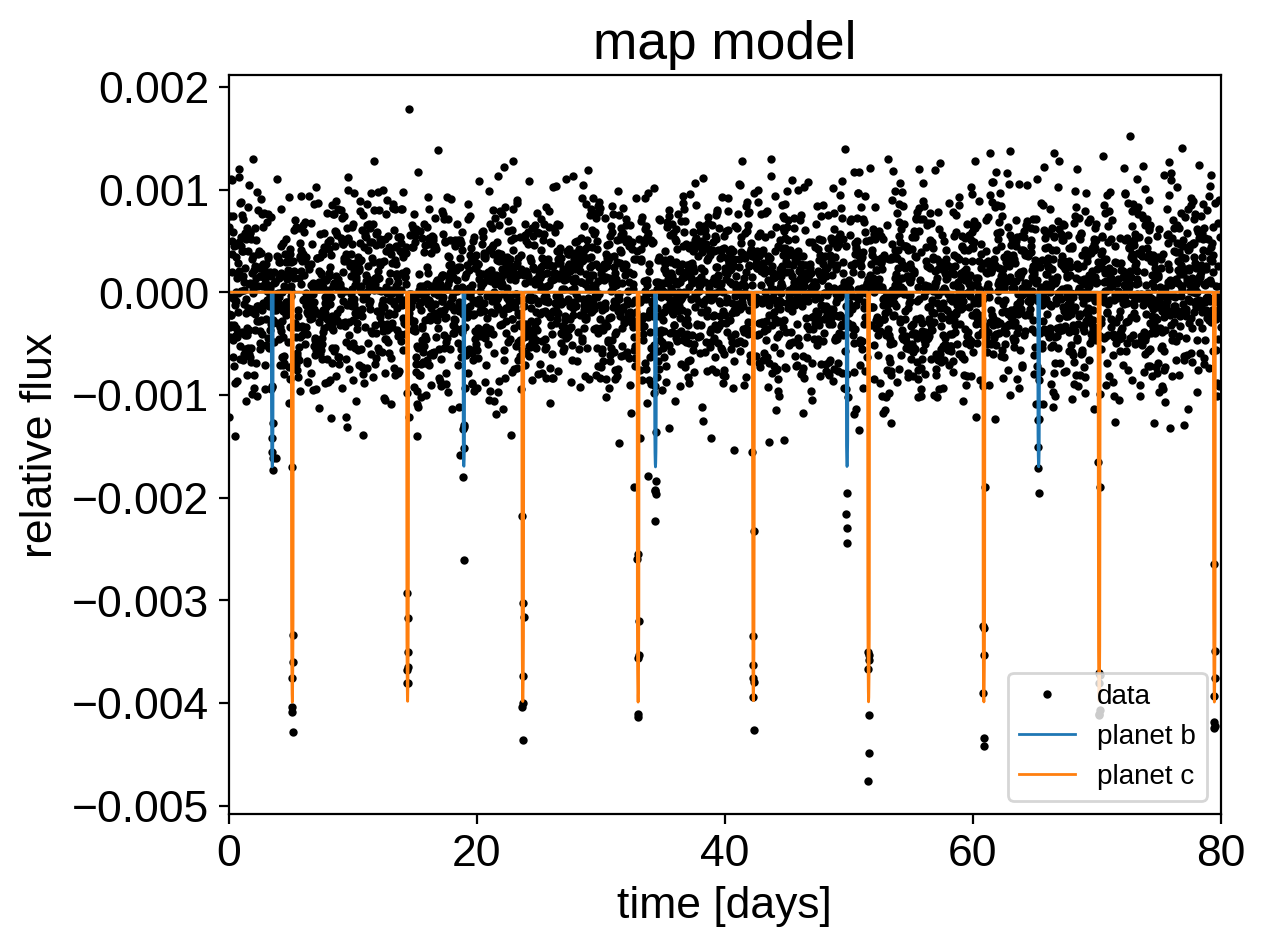

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=3000, draws=3000, start=map_soln, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/24000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/24000 [00:00<03:20, 119.76draws/s]

Sampling 4 chains:   0%|          | 25/24000 [00:00<06:23, 62.52draws/s] 

Sampling 4 chains:   0%|          | 29/24000 [00:00<08:58, 44.55draws/s]

Sampling 4 chains:   0%|          | 33/24000 [00:00<10:44, 37.19draws/s]

Sampling 4 chains:   0%|          | 37/24000 [00:00<12:07, 32.95draws/s]

Sampling 4 chains:   0%|          | 42/24000 [00:00<11:47, 33.86draws/s]

Sampling 4 chains:   0%|          | 46/24000 [00:01<12:17, 32.47draws/s]

Sampling 4 chains:   0%|          | 50/24000 [00:01<12:25, 32.15draws/s]

Sampling 4 chains:   0%|          | 54/24000 [00:01<13:03, 30.57draws/s]

Sampling 4 chains:   0%|          | 57/24000 [00:01<13:41, 29.13draws/s]

Sampling 4 chains:   0%|          | 61/24000 [00:01<13:31, 29.49draws/s]

Sampling 4 chains:   0%|          | 64/24000 [00:01<13:35, 29.37draws/s]

Sampling 4 chains:   0%|          | 67/24000 [00:01<14:52, 26.81draws/s]

Sampling 4 chains:   0%|          | 71/24000 [00:01<14:26, 27.61draws/s]

Sampling 4 chains:   0%|          | 75/24000 [00:02<14:15, 27.97draws/s]

Sampling 4 chains:   0%|          | 79/24000 [00:02<14:01, 28.41draws/s]

Sampling 4 chains:   0%|          | 83/24000 [00:02<14:53, 26.75draws/s]

Sampling 4 chains:   0%|          | 87/24000 [00:02<14:42, 27.09draws/s]

Sampling 4 chains:   0%|          | 92/24000 [00:02<13:22, 29.77draws/s]

Sampling 4 chains:   0%|          | 96/24000 [00:02<13:39, 29.17draws/s]

Sampling 4 chains:   0%|          | 100/24000 [00:02<13:25, 29.65draws/s]

Sampling 4 chains:   0%|          | 104/24000 [00:03<13:34, 29.35draws/s]

Sampling 4 chains:   0%|          | 107/24000 [00:03<14:34, 27.31draws/s]

Sampling 4 chains:   0%|          | 113/24000 [00:03<13:14, 30.06draws/s]

Sampling 4 chains:   0%|          | 117/24000 [00:03<12:53, 30.86draws/s]

Sampling 4 chains:   1%|          | 121/24000 [00:03<13:09, 30.25draws/s]

Sampling 4 chains:   1%|          | 125/24000 [00:03<13:57, 28.50draws/s]

Sampling 4 chains:   1%|          | 129/24000 [00:03<14:05, 28.25draws/s]

Sampling 4 chains:   1%|          | 133/24000 [00:04<13:30, 29.45draws/s]

Sampling 4 chains:   1%|          | 136/24000 [00:04<13:39, 29.12draws/s]

Sampling 4 chains:   1%|          | 139/24000 [00:04<14:21, 27.70draws/s]

Sampling 4 chains:   1%|          | 143/24000 [00:04<14:24, 27.59draws/s]

Sampling 4 chains:   1%|          | 146/24000 [00:04<14:08, 28.10draws/s]

Sampling 4 chains:   1%|          | 149/24000 [00:04<14:32, 27.33draws/s]

Sampling 4 chains:   1%|          | 152/24000 [00:04<15:41, 25.33draws/s]

Sampling 4 chains:   1%|          | 156/24000 [00:04<15:23, 25.82draws/s]

Sampling 4 chains:   1%|          | 160/24000 [00:05<14:48, 26.83draws/s]

Sampling 4 chains:   1%|          | 164/24000 [00:05<14:40, 27.07draws/s]

Sampling 4 chains:   1%|          | 169/24000 [00:05<13:20, 29.77draws/s]

Sampling 4 chains:   1%|          | 173/24000 [00:05<13:40, 29.03draws/s]

Sampling 4 chains:   1%|          | 176/24000 [00:05<13:47, 28.81draws/s]

Sampling 4 chains:   1%|          | 179/24000 [00:05<14:27, 27.47draws/s]

Sampling 4 chains:   1%|          | 183/24000 [00:05<14:18, 27.75draws/s]

Sampling 4 chains:   1%|          | 187/24000 [00:05<14:54, 26.62draws/s]

Sampling 4 chains:   1%|          | 191/24000 [00:06<14:12, 27.93draws/s]

Sampling 4 chains:   1%|          | 195/24000 [00:06<13:33, 29.25draws/s]

Sampling 4 chains:   1%|          | 199/24000 [00:06<13:12, 30.03draws/s]

Sampling 4 chains:   1%|          | 203/24000 [00:06<13:19, 29.76draws/s]

Sampling 4 chains:   1%|          | 207/24000 [00:06<13:23, 29.61draws/s]

Sampling 4 chains:   1%|          | 210/24000 [00:06<13:52, 28.57draws/s]

Sampling 4 chains:   1%|          | 214/24000 [00:06<13:48, 28.72draws/s]

Sampling 4 chains:   1%|          | 218/24000 [00:07<13:18, 29.77draws/s]

Sampling 4 chains:   1%|          | 222/24000 [00:07<12:47, 30.97draws/s]

Sampling 4 chains:   1%|          | 226/24000 [00:07<13:09, 30.10draws/s]

Sampling 4 chains:   1%|          | 230/24000 [00:07<12:59, 30.49draws/s]

Sampling 4 chains:   1%|          | 234/24000 [00:07<13:19, 29.73draws/s]

Sampling 4 chains:   1%|          | 238/24000 [00:07<13:57, 28.37draws/s]

Sampling 4 chains:   1%|          | 242/24000 [00:07<13:54, 28.47draws/s]

Sampling 4 chains:   1%|          | 246/24000 [00:08<15:01, 26.34draws/s]

Sampling 4 chains:   1%|          | 249/24000 [00:08<14:37, 27.06draws/s]

Sampling 4 chains:   1%|          | 253/24000 [00:08<14:48, 26.74draws/s]

Sampling 4 chains:   1%|          | 257/24000 [00:08<14:35, 27.12draws/s]

Sampling 4 chains:   1%|          | 261/24000 [00:08<14:44, 26.83draws/s]

Sampling 4 chains:   1%|          | 266/24000 [00:08<13:22, 29.59draws/s]

Sampling 4 chains:   1%|          | 270/24000 [00:08<12:57, 30.52draws/s]

Sampling 4 chains:   1%|          | 274/24000 [00:08<13:52, 28.49draws/s]

Sampling 4 chains:   1%|          | 277/24000 [00:09<13:40, 28.90draws/s]

Sampling 4 chains:   1%|          | 280/24000 [00:09<15:05, 26.18draws/s]

Sampling 4 chains:   1%|          | 283/24000 [00:09<14:48, 26.68draws/s]

Sampling 4 chains:   1%|          | 287/24000 [00:09<14:56, 26.46draws/s]

Sampling 4 chains:   1%|          | 291/24000 [00:09<14:48, 26.70draws/s]

Sampling 4 chains:   1%|          | 295/24000 [00:09<14:03, 28.11draws/s]

Sampling 4 chains:   1%|          | 298/24000 [00:09<14:18, 27.60draws/s]

Sampling 4 chains:   1%|▏         | 301/24000 [00:09<14:41, 26.88draws/s]

Sampling 4 chains:   1%|▏         | 305/24000 [00:10<14:36, 27.03draws/s]

Sampling 4 chains:   1%|▏         | 308/24000 [00:10<15:36, 25.31draws/s]

Sampling 4 chains:   1%|▏         | 312/24000 [00:10<15:42, 25.13draws/s]

Sampling 4 chains:   1%|▏         | 316/24000 [00:10<15:31, 25.42draws/s]

Sampling 4 chains:   1%|▏         | 320/24000 [00:10<15:03, 26.21draws/s]

Sampling 4 chains:   1%|▏         | 324/24000 [00:10<14:58, 26.35draws/s]

Sampling 4 chains:   1%|▏         | 327/24000 [00:11<16:07, 24.48draws/s]

Sampling 4 chains:   1%|▏         | 331/24000 [00:11<15:30, 25.43draws/s]

Sampling 4 chains:   1%|▏         | 335/24000 [00:11<14:30, 27.18draws/s]

Sampling 4 chains:   1%|▏         | 338/24000 [00:11<15:03, 26.20draws/s]

Sampling 4 chains:   1%|▏         | 342/24000 [00:11<15:09, 26.02draws/s]

Sampling 4 chains:   1%|▏         | 346/24000 [00:11<13:39, 28.87draws/s]

Sampling 4 chains:   1%|▏         | 350/24000 [00:11<15:10, 25.97draws/s]

Sampling 4 chains:   1%|▏         | 354/24000 [00:12<15:01, 26.22draws/s]

Sampling 4 chains:   1%|▏         | 358/24000 [00:12<14:40, 26.85draws/s]

Sampling 4 chains:   2%|▏         | 362/24000 [00:12<15:09, 25.98draws/s]

Sampling 4 chains:   2%|▏         | 366/24000 [00:12<15:05, 26.10draws/s]

Sampling 4 chains:   2%|▏         | 370/24000 [00:12<14:48, 26.60draws/s]

Sampling 4 chains:   2%|▏         | 373/24000 [00:12<14:42, 26.77draws/s]

Sampling 4 chains:   2%|▏         | 376/24000 [00:12<15:38, 25.18draws/s]

Sampling 4 chains:   2%|▏         | 380/24000 [00:13<15:31, 25.37draws/s]

Sampling 4 chains:   2%|▏         | 384/24000 [00:13<15:14, 25.82draws/s]

Sampling 4 chains:   2%|▏         | 388/24000 [00:13<15:16, 25.76draws/s]

Sampling 4 chains:   2%|▏         | 392/24000 [00:13<14:50, 26.52draws/s]

Sampling 4 chains:   2%|▏         | 396/24000 [00:13<14:20, 27.42draws/s]

Sampling 4 chains:   2%|▏         | 400/24000 [00:13<14:02, 28.02draws/s]

Sampling 4 chains:   2%|▏         | 403/24000 [00:13<14:06, 27.89draws/s]

Sampling 4 chains:   2%|▏         | 406/24000 [00:13<15:46, 24.92draws/s]

Sampling 4 chains:   2%|▏         | 410/24000 [00:14<15:04, 26.09draws/s]

Sampling 4 chains:   2%|▏         | 414/24000 [00:14<14:14, 27.59draws/s]

Sampling 4 chains:   2%|▏         | 418/24000 [00:14<13:49, 28.42draws/s]

Sampling 4 chains:   2%|▏         | 421/24000 [00:14<14:33, 27.01draws/s]

Sampling 4 chains:   2%|▏         | 425/24000 [00:14<14:45, 26.61draws/s]

Sampling 4 chains:   2%|▏         | 429/24000 [00:14<15:03, 26.07draws/s]

Sampling 4 chains:   2%|▏         | 433/24000 [00:14<14:17, 27.47draws/s]

Sampling 4 chains:   2%|▏         | 437/24000 [00:15<14:09, 27.74draws/s]

Sampling 4 chains:   2%|▏         | 440/24000 [00:15<14:31, 27.02draws/s]

Sampling 4 chains:   2%|▏         | 444/24000 [00:15<13:56, 28.16draws/s]

Sampling 4 chains:   2%|▏         | 448/24000 [00:15<13:28, 29.14draws/s]

Sampling 4 chains:   2%|▏         | 452/24000 [00:15<13:04, 30.03draws/s]

Sampling 4 chains:   2%|▏         | 456/24000 [00:15<12:58, 30.25draws/s]

Sampling 4 chains:   2%|▏         | 460/24000 [00:15<13:14, 29.61draws/s]

Sampling 4 chains:   2%|▏         | 463/24000 [00:15<14:20, 27.35draws/s]

Sampling 4 chains:   2%|▏         | 466/24000 [00:16<15:18, 25.63draws/s]

Sampling 4 chains:   2%|▏         | 470/24000 [00:16<14:30, 27.03draws/s]

Sampling 4 chains:   2%|▏         | 473/24000 [00:16<15:33, 25.20draws/s]

Sampling 4 chains:   2%|▏         | 477/24000 [00:16<15:28, 25.32draws/s]

Sampling 4 chains:   2%|▏         | 481/24000 [00:16<14:41, 26.69draws/s]

Sampling 4 chains:   2%|▏         | 485/24000 [00:16<14:08, 27.71draws/s]

Sampling 4 chains:   2%|▏         | 489/24000 [00:16<14:14, 27.51draws/s]

Sampling 4 chains:   2%|▏         | 493/24000 [00:17<14:55, 26.25draws/s]

Sampling 4 chains:   2%|▏         | 497/24000 [00:17<14:59, 26.12draws/s]

Sampling 4 chains:   2%|▏         | 501/24000 [00:17<14:27, 27.08draws/s]

Sampling 4 chains:   2%|▏         | 504/24000 [00:17<14:09, 27.66draws/s]

Sampling 4 chains:   2%|▏         | 508/24000 [00:17<13:57, 28.06draws/s]

Sampling 4 chains:   2%|▏         | 512/24000 [00:17<13:53, 28.19draws/s]

Sampling 4 chains:   2%|▏         | 515/24000 [00:17<14:02, 27.87draws/s]

Sampling 4 chains:   2%|▏         | 519/24000 [00:18<14:30, 26.99draws/s]

Sampling 4 chains:   2%|▏         | 523/24000 [00:18<14:05, 27.77draws/s]

Sampling 4 chains:   2%|▏         | 527/24000 [00:18<13:31, 28.93draws/s]

Sampling 4 chains:   2%|▏         | 531/24000 [00:18<13:08, 29.77draws/s]

Sampling 4 chains:   2%|▏         | 534/24000 [00:18<13:48, 28.32draws/s]

Sampling 4 chains:   2%|▏         | 537/24000 [00:18<13:40, 28.60draws/s]

Sampling 4 chains:   2%|▏         | 541/24000 [00:18<13:39, 28.62draws/s]

Sampling 4 chains:   2%|▏         | 544/24000 [00:18<14:31, 26.93draws/s]

Sampling 4 chains:   2%|▏         | 548/24000 [00:19<14:31, 26.91draws/s]

Sampling 4 chains:   2%|▏         | 552/24000 [00:19<14:21, 27.22draws/s]

Sampling 4 chains:   2%|▏         | 556/24000 [00:19<14:03, 27.81draws/s]

Sampling 4 chains:   2%|▏         | 560/24000 [00:19<13:49, 28.27draws/s]

Sampling 4 chains:   2%|▏         | 563/24000 [00:19<14:21, 27.19draws/s]

Sampling 4 chains:   2%|▏         | 567/24000 [00:19<14:25, 27.07draws/s]

Sampling 4 chains:   2%|▏         | 570/24000 [00:19<14:36, 26.74draws/s]

Sampling 4 chains:   2%|▏         | 573/24000 [00:19<14:14, 27.43draws/s]

Sampling 4 chains:   2%|▏         | 576/24000 [00:20<14:24, 27.08draws/s]

Sampling 4 chains:   2%|▏         | 579/24000 [00:20<15:19, 25.47draws/s]

Sampling 4 chains:   2%|▏         | 584/24000 [00:20<13:49, 28.24draws/s]

Sampling 4 chains:   2%|▏         | 590/24000 [00:20<11:39, 33.47draws/s]

Sampling 4 chains:   2%|▏         | 594/24000 [00:20<11:43, 33.27draws/s]

Sampling 4 chains:   2%|▏         | 599/24000 [00:20<11:25, 34.16draws/s]

Sampling 4 chains:   3%|▎         | 607/24000 [00:20<09:30, 41.03draws/s]

Sampling 4 chains:   3%|▎         | 612/24000 [00:20<10:31, 37.04draws/s]

Sampling 4 chains:   3%|▎         | 617/24000 [00:21<10:03, 38.73draws/s]

Sampling 4 chains:   3%|▎         | 623/24000 [00:21<09:06, 42.78draws/s]

Sampling 4 chains:   3%|▎         | 635/24000 [00:21<07:38, 50.97draws/s]

Sampling 4 chains:   3%|▎         | 652/24000 [00:21<06:05, 63.88draws/s]

Sampling 4 chains:   3%|▎         | 667/24000 [00:21<05:02, 77.07draws/s]

Sampling 4 chains:   3%|▎         | 685/24000 [00:21<04:11, 92.73draws/s]

Sampling 4 chains:   3%|▎         | 707/24000 [00:21<03:28, 111.82draws/s]

Sampling 4 chains:   3%|▎         | 737/24000 [00:21<02:50, 136.27draws/s]

Sampling 4 chains:   3%|▎         | 762/24000 [00:21<02:32, 152.07draws/s]

Sampling 4 chains:   3%|▎         | 783/24000 [00:22<02:20, 165.36draws/s]

Sampling 4 chains:   3%|▎         | 820/24000 [00:22<01:56, 198.14draws/s]

Sampling 4 chains:   4%|▎         | 863/24000 [00:22<01:38, 235.93draws/s]

Sampling 4 chains:   4%|▍         | 900/24000 [00:22<01:27, 264.29draws/s]

Sampling 4 chains:   4%|▍         | 941/24000 [00:22<01:19, 290.84draws/s]

Sampling 4 chains:   4%|▍         | 979/24000 [00:22<01:14, 308.94draws/s]

Sampling 4 chains:   4%|▍         | 1017/24000 [00:22<01:10, 325.63draws/s]

Sampling 4 chains:   4%|▍         | 1053/24000 [00:22<01:10, 325.91draws/s]

Sampling 4 chains:   5%|▍         | 1090/24000 [00:22<01:07, 337.98draws/s]

Sampling 4 chains:   5%|▍         | 1126/24000 [00:23<01:06, 342.55draws/s]

Sampling 4 chains:   5%|▍         | 1168/24000 [00:23<01:03, 361.79draws/s]

Sampling 4 chains:   5%|▌         | 1210/24000 [00:23<01:00, 377.23draws/s]

Sampling 4 chains:   5%|▌         | 1249/24000 [00:23<01:03, 360.88draws/s]

Sampling 4 chains:   5%|▌         | 1288/24000 [00:23<01:02, 364.63draws/s]

Sampling 4 chains:   6%|▌         | 1326/24000 [00:23<01:04, 351.24draws/s]

Sampling 4 chains:   6%|▌         | 1369/24000 [00:23<01:00, 371.63draws/s]

Sampling 4 chains:   6%|▌         | 1407/24000 [00:23<01:02, 364.33draws/s]

Sampling 4 chains:   6%|▌         | 1444/24000 [00:23<01:03, 356.73draws/s]

Sampling 4 chains:   6%|▌         | 1488/24000 [00:23<00:59, 377.88draws/s]

Sampling 4 chains:   6%|▋         | 1529/24000 [00:24<00:58, 385.82draws/s]

Sampling 4 chains:   7%|▋         | 1572/24000 [00:24<00:56, 395.37draws/s]

Sampling 4 chains:   7%|▋         | 1613/24000 [00:24<00:57, 391.03draws/s]

Sampling 4 chains:   7%|▋         | 1657/24000 [00:24<00:55, 402.02draws/s]

Sampling 4 chains:   7%|▋         | 1700/24000 [00:24<00:54, 409.46draws/s]

Sampling 4 chains:   7%|▋         | 1742/24000 [00:24<00:57, 385.90draws/s]

Sampling 4 chains:   7%|▋         | 1786/24000 [00:24<00:55, 397.84draws/s]

Sampling 4 chains:   8%|▊         | 1829/24000 [00:24<00:55, 403.06draws/s]

Sampling 4 chains:   8%|▊         | 1870/24000 [00:24<00:57, 385.97draws/s]

Sampling 4 chains:   8%|▊         | 1909/24000 [00:25<00:57, 384.45draws/s]

Sampling 4 chains:   8%|▊         | 1958/24000 [00:25<00:53, 410.92draws/s]

Sampling 4 chains:   8%|▊         | 2000/24000 [00:25<00:55, 395.92draws/s]

Sampling 4 chains:   9%|▊         | 2041/24000 [00:25<00:55, 393.71draws/s]

Sampling 4 chains:   9%|▊         | 2083/24000 [00:25<00:54, 399.83draws/s]

Sampling 4 chains:   9%|▉         | 2124/24000 [00:25<00:54, 398.08draws/s]

Sampling 4 chains:   9%|▉         | 2170/24000 [00:25<00:52, 412.16draws/s]

Sampling 4 chains:   9%|▉         | 2213/24000 [00:25<00:53, 410.05draws/s]

Sampling 4 chains:   9%|▉         | 2259/24000 [00:25<00:51, 423.14draws/s]

Sampling 4 chains:  10%|▉         | 2305/24000 [00:25<00:50, 432.65draws/s]

Sampling 4 chains:  10%|▉         | 2349/24000 [00:26<00:52, 415.57draws/s]

Sampling 4 chains:  10%|▉         | 2394/24000 [00:26<00:51, 417.65draws/s]

Sampling 4 chains:  10%|█         | 2438/24000 [00:26<00:51, 422.63draws/s]

Sampling 4 chains:  10%|█         | 2483/24000 [00:26<00:50, 426.62draws/s]

Sampling 4 chains:  11%|█         | 2526/24000 [00:26<00:53, 403.21draws/s]

Sampling 4 chains:  11%|█         | 2568/24000 [00:26<00:52, 404.92draws/s]

Sampling 4 chains:  11%|█         | 2609/24000 [00:26<00:53, 396.62draws/s]

Sampling 4 chains:  11%|█         | 2653/24000 [00:26<00:52, 408.57draws/s]

Sampling 4 chains:  11%|█         | 2695/24000 [00:26<00:54, 389.43draws/s]

Sampling 4 chains:  11%|█▏        | 2735/24000 [00:27<00:54, 388.90draws/s]

Sampling 4 chains:  12%|█▏        | 2775/24000 [00:27<00:54, 391.57draws/s]

Sampling 4 chains:  12%|█▏        | 2820/24000 [00:27<00:52, 407.18draws/s]

Sampling 4 chains:  12%|█▏        | 2862/24000 [00:27<00:51, 409.53draws/s]

Sampling 4 chains:  12%|█▏        | 2904/24000 [00:27<00:53, 397.74draws/s]

Sampling 4 chains:  12%|█▏        | 2944/24000 [00:27<00:53, 393.47draws/s]

Sampling 4 chains:  12%|█▏        | 2989/24000 [00:27<00:51, 408.33draws/s]

Sampling 4 chains:  13%|█▎        | 3031/24000 [00:27<00:53, 390.68draws/s]

Sampling 4 chains:  13%|█▎        | 3074/24000 [00:27<00:52, 398.99draws/s]

Sampling 4 chains:  13%|█▎        | 3120/24000 [00:27<00:50, 415.20draws/s]

Sampling 4 chains:  13%|█▎        | 3162/24000 [00:28<00:50, 410.56draws/s]

Sampling 4 chains:  13%|█▎        | 3204/24000 [00:28<00:51, 406.13draws/s]

Sampling 4 chains:  14%|█▎        | 3257/24000 [00:28<00:47, 434.20draws/s]

Sampling 4 chains:  14%|█▍        | 3302/24000 [00:28<00:49, 421.16draws/s]

Sampling 4 chains:  14%|█▍        | 3345/24000 [00:28<00:49, 417.18draws/s]

Sampling 4 chains:  14%|█▍        | 3391/24000 [00:28<00:48, 426.26draws/s]

Sampling 4 chains:  14%|█▍        | 3434/24000 [00:28<00:48, 420.10draws/s]

Sampling 4 chains:  14%|█▍        | 3479/24000 [00:28<00:48, 427.25draws/s]

Sampling 4 chains:  15%|█▍        | 3522/24000 [00:28<00:48, 418.15draws/s]

Sampling 4 chains:  15%|█▍        | 3565/24000 [00:29<00:49, 409.42draws/s]

Sampling 4 chains:  15%|█▌        | 3612/24000 [00:29<00:48, 424.54draws/s]

Sampling 4 chains:  15%|█▌        | 3666/24000 [00:29<00:45, 447.92draws/s]

Sampling 4 chains:  15%|█▌        | 3719/24000 [00:29<00:43, 468.88draws/s]

Sampling 4 chains:  16%|█▌        | 3767/24000 [00:29<00:43, 466.04draws/s]

Sampling 4 chains:  16%|█▌        | 3815/24000 [00:29<00:43, 461.88draws/s]

Sampling 4 chains:  16%|█▌        | 3862/24000 [00:29<00:44, 452.26draws/s]

Sampling 4 chains:  16%|█▋        | 3911/24000 [00:29<00:43, 457.93draws/s]

Sampling 4 chains:  16%|█▋        | 3957/24000 [00:29<00:44, 455.27draws/s]

Sampling 4 chains:  17%|█▋        | 4005/24000 [00:29<00:43, 455.29draws/s]

Sampling 4 chains:  17%|█▋        | 4051/24000 [00:30<00:43, 455.30draws/s]

Sampling 4 chains:  17%|█▋        | 4097/24000 [00:30<00:44, 450.09draws/s]

Sampling 4 chains:  17%|█▋        | 4143/24000 [00:30<00:43, 452.71draws/s]

Sampling 4 chains:  17%|█▋        | 4189/24000 [00:30<00:44, 442.28draws/s]

Sampling 4 chains:  18%|█▊        | 4240/24000 [00:30<00:42, 460.42draws/s]

Sampling 4 chains:  18%|█▊        | 4287/24000 [00:30<00:43, 455.89draws/s]

Sampling 4 chains:  18%|█▊        | 4333/24000 [00:30<00:46, 425.90draws/s]

Sampling 4 chains:  18%|█▊        | 4377/24000 [00:30<00:46, 420.78draws/s]

Sampling 4 chains:  18%|█▊        | 4420/24000 [00:30<00:47, 415.26draws/s]

Sampling 4 chains:  19%|█▊        | 4466/24000 [00:31<00:45, 426.56draws/s]

Sampling 4 chains:  19%|█▉        | 4512/24000 [00:31<00:45, 429.32draws/s]

Sampling 4 chains:  19%|█▉        | 4561/24000 [00:31<00:43, 443.82draws/s]

Sampling 4 chains:  19%|█▉        | 4606/24000 [00:31<00:44, 439.66draws/s]

Sampling 4 chains:  19%|█▉        | 4651/24000 [00:31<00:44, 431.84draws/s]

Sampling 4 chains:  20%|█▉        | 4695/24000 [00:31<00:44, 431.72draws/s]

Sampling 4 chains:  20%|█▉        | 4739/24000 [00:31<00:45, 427.72draws/s]

Sampling 4 chains:  20%|█▉        | 4786/24000 [00:31<00:43, 439.33draws/s]

Sampling 4 chains:  20%|██        | 4831/24000 [00:31<00:46, 409.49draws/s]

Sampling 4 chains:  20%|██        | 4873/24000 [00:32<00:47, 401.81draws/s]

Sampling 4 chains:  20%|██        | 4917/24000 [00:32<00:46, 409.58draws/s]

Sampling 4 chains:  21%|██        | 4962/24000 [00:32<00:45, 420.82draws/s]

Sampling 4 chains:  21%|██        | 5008/24000 [00:32<00:44, 431.23draws/s]

Sampling 4 chains:  21%|██        | 5052/24000 [00:32<00:45, 414.39draws/s]

Sampling 4 chains:  21%|██        | 5099/24000 [00:32<00:44, 427.24draws/s]

Sampling 4 chains:  21%|██▏       | 5147/24000 [00:32<00:42, 440.61draws/s]

Sampling 4 chains:  22%|██▏       | 5200/24000 [00:32<00:40, 459.49draws/s]

Sampling 4 chains:  22%|██▏       | 5247/24000 [00:32<00:40, 460.32draws/s]

Sampling 4 chains:  22%|██▏       | 5294/24000 [00:32<00:41, 453.95draws/s]

Sampling 4 chains:  22%|██▏       | 5340/24000 [00:33<00:41, 452.89draws/s]

Sampling 4 chains:  22%|██▏       | 5387/24000 [00:33<00:40, 457.44draws/s]

Sampling 4 chains:  23%|██▎       | 5433/24000 [00:33<00:42, 436.38draws/s]

Sampling 4 chains:  23%|██▎       | 5477/24000 [00:33<00:44, 417.79draws/s]

Sampling 4 chains:  23%|██▎       | 5520/24000 [00:33<00:44, 419.31draws/s]

Sampling 4 chains:  23%|██▎       | 5564/24000 [00:33<00:43, 422.43draws/s]

Sampling 4 chains:  23%|██▎       | 5614/24000 [00:33<00:41, 441.97draws/s]

Sampling 4 chains:  24%|██▎       | 5659/24000 [00:33<00:42, 427.86draws/s]

Sampling 4 chains:  24%|██▍       | 5703/24000 [00:33<00:42, 427.72draws/s]

Sampling 4 chains:  24%|██▍       | 5747/24000 [00:34<00:42, 427.45draws/s]

Sampling 4 chains:  24%|██▍       | 5795/24000 [00:34<00:41, 441.60draws/s]

Sampling 4 chains:  24%|██▍       | 5842/24000 [00:34<00:40, 447.82draws/s]

Sampling 4 chains:  25%|██▍       | 5887/24000 [00:34<00:41, 439.94draws/s]

Sampling 4 chains:  25%|██▍       | 5932/24000 [00:34<00:42, 425.49draws/s]

Sampling 4 chains:  25%|██▍       | 5976/24000 [00:34<00:42, 426.10draws/s]

Sampling 4 chains:  25%|██▌       | 6019/24000 [00:34<00:42, 421.64draws/s]

Sampling 4 chains:  25%|██▌       | 6062/24000 [00:34<00:42, 422.23draws/s]

Sampling 4 chains:  25%|██▌       | 6105/24000 [00:34<00:44, 405.72draws/s]

Sampling 4 chains:  26%|██▌       | 6147/24000 [00:34<00:44, 405.00draws/s]

Sampling 4 chains:  26%|██▌       | 6193/24000 [00:35<00:42, 418.38draws/s]

Sampling 4 chains:  26%|██▌       | 6237/24000 [00:35<00:42, 422.84draws/s]

Sampling 4 chains:  26%|██▌       | 6283/24000 [00:35<00:41, 431.56draws/s]

Sampling 4 chains:  26%|██▋       | 6327/24000 [00:35<00:40, 431.16draws/s]

Sampling 4 chains:  27%|██▋       | 6377/24000 [00:35<00:39, 448.01draws/s]

Sampling 4 chains:  27%|██▋       | 6423/24000 [00:35<00:39, 445.41draws/s]

Sampling 4 chains:  27%|██▋       | 6468/24000 [00:35<00:40, 433.57draws/s]

Sampling 4 chains:  27%|██▋       | 6523/24000 [00:35<00:37, 462.65draws/s]

Sampling 4 chains:  27%|██▋       | 6572/24000 [00:35<00:37, 469.80draws/s]

Sampling 4 chains:  28%|██▊       | 6620/24000 [00:35<00:37, 465.64draws/s]

Sampling 4 chains:  28%|██▊       | 6672/24000 [00:36<00:36, 478.78draws/s]

Sampling 4 chains:  28%|██▊       | 6722/24000 [00:36<00:35, 483.96draws/s]

Sampling 4 chains:  28%|██▊       | 6775/24000 [00:36<00:34, 492.87draws/s]

Sampling 4 chains:  28%|██▊       | 6825/24000 [00:36<00:35, 480.79draws/s]

Sampling 4 chains:  29%|██▊       | 6874/24000 [00:36<00:37, 452.45draws/s]

Sampling 4 chains:  29%|██▉       | 6923/24000 [00:36<00:36, 461.93draws/s]

Sampling 4 chains:  29%|██▉       | 6972/24000 [00:36<00:36, 469.66draws/s]

Sampling 4 chains:  29%|██▉       | 7021/24000 [00:36<00:35, 474.46draws/s]

Sampling 4 chains:  29%|██▉       | 7069/24000 [00:36<00:36, 458.59draws/s]

Sampling 4 chains:  30%|██▉       | 7116/24000 [00:37<00:37, 451.76draws/s]

Sampling 4 chains:  30%|██▉       | 7163/24000 [00:37<00:36, 456.86draws/s]

Sampling 4 chains:  30%|███       | 7211/24000 [00:37<00:36, 462.20draws/s]

Sampling 4 chains:  30%|███       | 7258/24000 [00:37<00:36, 457.06draws/s]

Sampling 4 chains:  30%|███       | 7304/24000 [00:37<00:36, 453.33draws/s]

Sampling 4 chains:  31%|███       | 7359/24000 [00:37<00:34, 475.96draws/s]

Sampling 4 chains:  31%|███       | 7407/24000 [00:37<00:35, 467.89draws/s]

Sampling 4 chains:  31%|███       | 7457/24000 [00:37<00:35, 472.31draws/s]

Sampling 4 chains:  31%|███▏      | 7505/24000 [00:37<00:34, 473.66draws/s]

Sampling 4 chains:  31%|███▏      | 7553/24000 [00:37<00:34, 472.46draws/s]

Sampling 4 chains:  32%|███▏      | 7601/24000 [00:38<00:35, 463.47draws/s]

Sampling 4 chains:  32%|███▏      | 7648/24000 [00:38<00:36, 452.53draws/s]

Sampling 4 chains:  32%|███▏      | 7696/24000 [00:38<00:35, 457.00draws/s]

Sampling 4 chains:  32%|███▏      | 7742/24000 [00:38<00:35, 457.78draws/s]

Sampling 4 chains:  32%|███▏      | 7789/24000 [00:38<00:35, 461.28draws/s]

Sampling 4 chains:  33%|███▎      | 7836/24000 [00:38<00:35, 458.90draws/s]

Sampling 4 chains:  33%|███▎      | 7882/24000 [00:38<00:36, 446.98draws/s]

Sampling 4 chains:  33%|███▎      | 7927/24000 [00:38<00:36, 439.25draws/s]

Sampling 4 chains:  33%|███▎      | 7974/24000 [00:38<00:35, 446.85draws/s]

Sampling 4 chains:  33%|███▎      | 8025/24000 [00:39<00:34, 459.38draws/s]

Sampling 4 chains:  34%|███▎      | 8072/24000 [00:39<00:35, 452.66draws/s]

Sampling 4 chains:  34%|███▍      | 8119/24000 [00:39<00:34, 457.71draws/s]

Sampling 4 chains:  34%|███▍      | 8165/24000 [00:39<00:35, 445.89draws/s]

Sampling 4 chains:  34%|███▍      | 8214/24000 [00:39<00:34, 456.57draws/s]

Sampling 4 chains:  34%|███▍      | 8260/24000 [00:39<00:34, 452.86draws/s]

Sampling 4 chains:  35%|███▍      | 8306/24000 [00:39<00:37, 421.21draws/s]

Sampling 4 chains:  35%|███▍      | 8349/24000 [00:39<00:37, 420.73draws/s]

Sampling 4 chains:  35%|███▍      | 8394/24000 [00:39<00:36, 424.92draws/s]

Sampling 4 chains:  35%|███▌      | 8444/24000 [00:39<00:35, 442.46draws/s]

Sampling 4 chains:  35%|███▌      | 8493/24000 [00:40<00:34, 454.68draws/s]

Sampling 4 chains:  36%|███▌      | 8542/24000 [00:40<00:33, 462.45draws/s]

Sampling 4 chains:  36%|███▌      | 8589/24000 [00:40<00:33, 463.22draws/s]

Sampling 4 chains:  36%|███▌      | 8638/24000 [00:40<00:32, 465.57draws/s]

Sampling 4 chains:  36%|███▌      | 8692/24000 [00:40<00:31, 485.03draws/s]

Sampling 4 chains:  36%|███▋      | 8741/24000 [00:40<00:31, 478.98draws/s]

Sampling 4 chains:  37%|███▋      | 8793/24000 [00:40<00:31, 490.50draws/s]

Sampling 4 chains:  37%|███▋      | 8848/24000 [00:40<00:30, 503.88draws/s]

Sampling 4 chains:  37%|███▋      | 8899/24000 [00:40<00:30, 500.92draws/s]

Sampling 4 chains:  37%|███▋      | 8950/24000 [00:40<00:30, 497.82draws/s]

Sampling 4 chains:  38%|███▊      | 9000/24000 [00:41<00:30, 498.20draws/s]

Sampling 4 chains:  38%|███▊      | 9050/24000 [00:41<00:30, 493.13draws/s]

Sampling 4 chains:  38%|███▊      | 9100/24000 [00:41<00:30, 486.52draws/s]

Sampling 4 chains:  38%|███▊      | 9156/24000 [00:41<00:29, 505.74draws/s]

Sampling 4 chains:  38%|███▊      | 9213/24000 [00:41<00:28, 518.83draws/s]

Sampling 4 chains:  39%|███▊      | 9267/24000 [00:41<00:28, 523.53draws/s]

Sampling 4 chains:  39%|███▉      | 9323/24000 [00:41<00:27, 529.77draws/s]

Sampling 4 chains:  39%|███▉      | 9382/24000 [00:41<00:26, 544.18draws/s]

Sampling 4 chains:  39%|███▉      | 9437/24000 [00:41<00:27, 529.20draws/s]

Sampling 4 chains:  40%|███▉      | 9491/24000 [00:42<00:28, 513.76draws/s]

Sampling 4 chains:  40%|███▉      | 9544/24000 [00:42<00:27, 518.30draws/s]

Sampling 4 chains:  40%|███▉      | 9597/24000 [00:42<00:27, 515.32draws/s]

Sampling 4 chains:  40%|████      | 9650/24000 [00:42<00:27, 512.98draws/s]

Sampling 4 chains:  40%|████      | 9702/24000 [00:42<00:28, 500.79draws/s]

Sampling 4 chains:  41%|████      | 9754/24000 [00:42<00:28, 505.45draws/s]

Sampling 4 chains:  41%|████      | 9810/24000 [00:42<00:27, 518.63draws/s]

Sampling 4 chains:  41%|████      | 9863/24000 [00:42<00:27, 516.22draws/s]

Sampling 4 chains:  41%|████▏     | 9918/24000 [00:42<00:26, 522.55draws/s]

Sampling 4 chains:  42%|████▏     | 9978/24000 [00:42<00:25, 542.99draws/s]

Sampling 4 chains:  42%|████▏     | 10034/24000 [00:43<00:25, 541.66draws/s]

Sampling 4 chains:  42%|████▏     | 10090/24000 [00:43<00:25, 543.03draws/s]

Sampling 4 chains:  42%|████▏     | 10145/24000 [00:43<00:25, 537.38draws/s]

Sampling 4 chains:  42%|████▏     | 10199/24000 [00:43<00:25, 533.16draws/s]

Sampling 4 chains:  43%|████▎     | 10255/24000 [00:43<00:25, 539.88draws/s]

Sampling 4 chains:  43%|████▎     | 10312/24000 [00:43<00:24, 547.76draws/s]

Sampling 4 chains:  43%|████▎     | 10367/24000 [00:43<00:25, 525.94draws/s]

Sampling 4 chains:  43%|████▎     | 10420/24000 [00:43<00:26, 514.59draws/s]

Sampling 4 chains:  44%|████▎     | 10472/24000 [00:43<00:26, 514.29draws/s]

Sampling 4 chains:  44%|████▍     | 10525/24000 [00:44<00:25, 518.42draws/s]

Sampling 4 chains:  44%|████▍     | 10577/24000 [00:44<00:25, 517.97draws/s]

Sampling 4 chains:  44%|████▍     | 10629/24000 [00:44<00:26, 507.28draws/s]

Sampling 4 chains:  44%|████▍     | 10680/24000 [00:44<00:26, 498.25draws/s]

Sampling 4 chains:  45%|████▍     | 10732/24000 [00:44<00:26, 503.08draws/s]

Sampling 4 chains:  45%|████▍     | 10784/24000 [00:44<00:26, 507.79draws/s]

Sampling 4 chains:  45%|████▌     | 10839/24000 [00:44<00:25, 518.66draws/s]

Sampling 4 chains:  45%|████▌     | 10891/24000 [00:44<00:25, 509.78draws/s]

Sampling 4 chains:  46%|████▌     | 10944/24000 [00:44<00:25, 514.30draws/s]

Sampling 4 chains:  46%|████▌     | 10997/24000 [00:44<00:25, 518.38draws/s]

Sampling 4 chains:  46%|████▌     | 11049/24000 [00:45<00:26, 495.88draws/s]

Sampling 4 chains:  46%|████▋     | 11105/24000 [00:45<00:25, 511.42draws/s]

Sampling 4 chains:  46%|████▋     | 11159/24000 [00:45<00:24, 518.15draws/s]

Sampling 4 chains:  47%|████▋     | 11218/24000 [00:45<00:23, 535.94draws/s]

Sampling 4 chains:  47%|████▋     | 11274/24000 [00:45<00:23, 540.70draws/s]

Sampling 4 chains:  47%|████▋     | 11330/24000 [00:45<00:23, 544.49draws/s]

Sampling 4 chains:  47%|████▋     | 11385/24000 [00:45<00:23, 533.16draws/s]

Sampling 4 chains:  48%|████▊     | 11439/24000 [00:45<00:23, 523.55draws/s]

Sampling 4 chains:  48%|████▊     | 11492/24000 [00:45<00:23, 524.41draws/s]

Sampling 4 chains:  48%|████▊     | 11545/24000 [00:45<00:23, 521.57draws/s]

Sampling 4 chains:  48%|████▊     | 11600/24000 [00:46<00:23, 525.47draws/s]

Sampling 4 chains:  49%|████▊     | 11653/24000 [00:46<00:24, 503.90draws/s]

Sampling 4 chains:  49%|████▉     | 11704/24000 [00:46<00:25, 480.10draws/s]

Sampling 4 chains:  49%|████▉     | 11753/24000 [00:46<00:26, 460.95draws/s]

Sampling 4 chains:  49%|████▉     | 11806/24000 [00:46<00:25, 479.03draws/s]

Sampling 4 chains:  49%|████▉     | 11860/24000 [00:46<00:24, 494.75draws/s]

Sampling 4 chains:  50%|████▉     | 11912/24000 [00:46<00:24, 496.51draws/s]

Sampling 4 chains:  50%|████▉     | 11963/24000 [00:46<00:24, 498.78draws/s]

Sampling 4 chains:  50%|█████     | 12018/24000 [00:46<00:23, 511.60draws/s]

Sampling 4 chains:  50%|█████     | 12072/24000 [00:47<00:22, 519.50draws/s]

Sampling 4 chains:  51%|█████     | 12125/24000 [00:47<00:22, 522.36draws/s]

Sampling 4 chains:  51%|█████     | 12178/24000 [00:47<00:22, 514.56draws/s]

Sampling 4 chains:  51%|█████     | 12232/24000 [00:47<00:22, 520.56draws/s]

Sampling 4 chains:  51%|█████     | 12285/24000 [00:47<00:22, 518.78draws/s]

Sampling 4 chains:  51%|█████▏    | 12338/24000 [00:47<00:22, 521.12draws/s]

Sampling 4 chains:  52%|█████▏    | 12391/24000 [00:47<00:22, 521.80draws/s]

Sampling 4 chains:  52%|█████▏    | 12446/24000 [00:47<00:21, 527.52draws/s]

Sampling 4 chains:  52%|█████▏    | 12499/24000 [00:47<00:21, 524.81draws/s]

Sampling 4 chains:  52%|█████▏    | 12553/24000 [00:47<00:21, 525.07draws/s]

Sampling 4 chains:  53%|█████▎    | 12606/24000 [00:48<00:21, 524.05draws/s]

Sampling 4 chains:  53%|█████▎    | 12660/24000 [00:48<00:21, 526.69draws/s]

Sampling 4 chains:  53%|█████▎    | 12713/24000 [00:48<00:21, 517.58draws/s]

Sampling 4 chains:  53%|█████▎    | 12770/24000 [00:48<00:21, 530.58draws/s]

Sampling 4 chains:  53%|█████▎    | 12824/24000 [00:48<00:21, 527.72draws/s]

Sampling 4 chains:  54%|█████▎    | 12877/24000 [00:48<00:21, 527.05draws/s]

Sampling 4 chains:  54%|█████▍    | 12930/24000 [00:48<00:21, 521.69draws/s]

Sampling 4 chains:  54%|█████▍    | 12984/24000 [00:48<00:20, 526.21draws/s]

Sampling 4 chains:  54%|█████▍    | 13038/24000 [00:48<00:20, 529.37draws/s]

Sampling 4 chains:  55%|█████▍    | 13093/24000 [00:48<00:20, 532.07draws/s]

Sampling 4 chains:  55%|█████▍    | 13148/24000 [00:49<00:20, 532.49draws/s]

Sampling 4 chains:  55%|█████▌    | 13202/24000 [00:49<00:20, 532.31draws/s]

Sampling 4 chains:  55%|█████▌    | 13259/24000 [00:49<00:19, 541.69draws/s]

Sampling 4 chains:  55%|█████▌    | 13316/24000 [00:49<00:19, 549.60draws/s]

Sampling 4 chains:  56%|█████▌    | 13373/24000 [00:49<00:19, 553.33draws/s]

Sampling 4 chains:  56%|█████▌    | 13429/24000 [00:49<00:19, 542.29draws/s]

Sampling 4 chains:  56%|█████▌    | 13487/24000 [00:49<00:19, 548.97draws/s]

Sampling 4 chains:  56%|█████▋    | 13542/24000 [00:49<00:19, 536.09draws/s]

Sampling 4 chains:  57%|█████▋    | 13597/24000 [00:49<00:19, 538.64draws/s]

Sampling 4 chains:  57%|█████▋    | 13651/24000 [00:50<00:19, 524.24draws/s]

Sampling 4 chains:  57%|█████▋    | 13705/24000 [00:50<00:19, 524.44draws/s]

Sampling 4 chains:  57%|█████▋    | 13760/24000 [00:50<00:19, 529.22draws/s]

Sampling 4 chains:  58%|█████▊    | 13816/24000 [00:50<00:19, 535.79draws/s]

Sampling 4 chains:  58%|█████▊    | 13873/24000 [00:50<00:18, 538.13draws/s]

Sampling 4 chains:  58%|█████▊    | 13927/24000 [00:50<00:18, 533.75draws/s]

Sampling 4 chains:  58%|█████▊    | 13981/24000 [00:50<00:19, 526.71draws/s]

Sampling 4 chains:  58%|█████▊    | 14035/24000 [00:50<00:18, 530.42draws/s]

Sampling 4 chains:  59%|█████▊    | 14089/24000 [00:50<00:19, 515.03draws/s]

Sampling 4 chains:  59%|█████▉    | 14143/24000 [00:50<00:18, 522.21draws/s]

Sampling 4 chains:  59%|█████▉    | 14196/24000 [00:51<00:19, 511.15draws/s]

Sampling 4 chains:  59%|█████▉    | 14248/24000 [00:51<00:19, 492.24draws/s]

Sampling 4 chains:  60%|█████▉    | 14298/24000 [00:51<00:19, 486.28draws/s]

Sampling 4 chains:  60%|█████▉    | 14347/24000 [00:51<00:19, 487.06draws/s]

Sampling 4 chains:  60%|█████▉    | 14396/24000 [00:51<00:20, 476.91draws/s]

Sampling 4 chains:  60%|██████    | 14444/24000 [00:51<00:20, 472.00draws/s]

Sampling 4 chains:  60%|██████    | 14494/24000 [00:51<00:19, 477.38draws/s]

Sampling 4 chains:  61%|██████    | 14543/24000 [00:51<00:19, 475.28draws/s]

Sampling 4 chains:  61%|██████    | 14594/24000 [00:51<00:19, 485.03draws/s]

Sampling 4 chains:  61%|██████    | 14644/24000 [00:51<00:19, 487.38draws/s]

Sampling 4 chains:  61%|██████    | 14693/24000 [00:52<00:19, 483.10draws/s]

Sampling 4 chains:  61%|██████▏   | 14742/24000 [00:52<00:19, 482.55draws/s]

Sampling 4 chains:  62%|██████▏   | 14796/24000 [00:52<00:18, 496.13draws/s]

Sampling 4 chains:  62%|██████▏   | 14849/24000 [00:52<00:18, 505.20draws/s]

Sampling 4 chains:  62%|██████▏   | 14907/24000 [00:52<00:17, 525.50draws/s]

Sampling 4 chains:  62%|██████▏   | 14960/24000 [00:52<00:17, 525.09draws/s]

Sampling 4 chains:  63%|██████▎   | 15017/24000 [00:52<00:16, 537.35draws/s]

Sampling 4 chains:  63%|██████▎   | 15071/24000 [00:52<00:17, 524.35draws/s]

Sampling 4 chains:  63%|██████▎   | 15124/24000 [00:52<00:17, 495.98draws/s]

Sampling 4 chains:  63%|██████▎   | 15175/24000 [00:53<00:18, 481.92draws/s]

Sampling 4 chains:  63%|██████▎   | 15229/24000 [00:53<00:17, 497.61draws/s]

Sampling 4 chains:  64%|██████▎   | 15283/24000 [00:53<00:17, 505.31draws/s]

Sampling 4 chains:  64%|██████▍   | 15339/24000 [00:53<00:16, 516.35draws/s]

Sampling 4 chains:  64%|██████▍   | 15391/24000 [00:53<00:17, 506.30draws/s]

Sampling 4 chains:  64%|██████▍   | 15447/24000 [00:53<00:16, 520.58draws/s]

Sampling 4 chains:  65%|██████▍   | 15503/24000 [00:53<00:16, 531.05draws/s]

Sampling 4 chains:  65%|██████▍   | 15557/24000 [00:53<00:16, 508.04draws/s]

Sampling 4 chains:  65%|██████▌   | 15609/24000 [00:53<00:17, 472.55draws/s]

Sampling 4 chains:  65%|██████▌   | 15658/24000 [00:54<00:18, 462.89draws/s]

Sampling 4 chains:  65%|██████▌   | 15710/24000 [00:54<00:17, 477.47draws/s]

Sampling 4 chains:  66%|██████▌   | 15764/24000 [00:54<00:16, 492.10draws/s]

Sampling 4 chains:  66%|██████▌   | 15819/24000 [00:54<00:16, 504.95draws/s]

Sampling 4 chains:  66%|██████▌   | 15874/24000 [00:54<00:15, 514.82draws/s]

Sampling 4 chains:  66%|██████▋   | 15926/24000 [00:54<00:17, 470.15draws/s]

Sampling 4 chains:  67%|██████▋   | 15975/24000 [00:54<00:18, 436.09draws/s]

Sampling 4 chains:  67%|██████▋   | 16020/24000 [00:54<00:18, 434.66draws/s]

Sampling 4 chains:  67%|██████▋   | 16073/24000 [00:54<00:17, 458.91draws/s]

Sampling 4 chains:  67%|██████▋   | 16124/24000 [00:54<00:16, 472.01draws/s]

Sampling 4 chains:  67%|██████▋   | 16182/24000 [00:55<00:15, 496.94draws/s]

Sampling 4 chains:  68%|██████▊   | 16238/24000 [00:55<00:15, 509.28draws/s]

Sampling 4 chains:  68%|██████▊   | 16293/24000 [00:55<00:14, 520.48draws/s]

Sampling 4 chains:  68%|██████▊   | 16346/24000 [00:55<00:14, 522.70draws/s]

Sampling 4 chains:  68%|██████▊   | 16399/24000 [00:55<00:15, 479.38draws/s]

Sampling 4 chains:  69%|██████▊   | 16448/24000 [00:55<00:15, 472.38draws/s]

Sampling 4 chains:  69%|██████▉   | 16501/24000 [00:55<00:15, 487.15draws/s]

Sampling 4 chains:  69%|██████▉   | 16551/24000 [00:55<00:15, 482.21draws/s]

Sampling 4 chains:  69%|██████▉   | 16602/24000 [00:55<00:15, 489.46draws/s]

Sampling 4 chains:  69%|██████▉   | 16658/24000 [00:56<00:14, 505.11draws/s]

Sampling 4 chains:  70%|██████▉   | 16711/24000 [00:56<00:14, 510.61draws/s]

Sampling 4 chains:  70%|██████▉   | 16766/24000 [00:56<00:13, 519.35draws/s]

Sampling 4 chains:  70%|███████   | 16819/24000 [00:56<00:13, 521.97draws/s]

Sampling 4 chains:  70%|███████   | 16872/24000 [00:56<00:13, 523.79draws/s]

Sampling 4 chains:  71%|███████   | 16927/24000 [00:56<00:13, 528.91draws/s]

Sampling 4 chains:  71%|███████   | 16983/24000 [00:56<00:13, 536.92draws/s]

Sampling 4 chains:  71%|███████   | 17037/24000 [00:56<00:12, 536.90draws/s]

Sampling 4 chains:  71%|███████   | 17094/24000 [00:56<00:12, 542.70draws/s]

Sampling 4 chains:  71%|███████▏  | 17149/24000 [00:56<00:12, 539.04draws/s]

Sampling 4 chains:  72%|███████▏  | 17203/24000 [00:57<00:12, 531.78draws/s]

Sampling 4 chains:  72%|███████▏  | 17261/24000 [00:57<00:12, 543.32draws/s]

Sampling 4 chains:  72%|███████▏  | 17317/24000 [00:57<00:12, 545.62draws/s]

Sampling 4 chains:  72%|███████▏  | 17372/24000 [00:57<00:12, 544.33draws/s]

Sampling 4 chains:  73%|███████▎  | 17427/24000 [00:57<00:12, 533.26draws/s]

Sampling 4 chains:  73%|███████▎  | 17481/24000 [00:57<00:12, 522.11draws/s]

Sampling 4 chains:  73%|███████▎  | 17536/24000 [00:57<00:12, 527.92draws/s]

Sampling 4 chains:  73%|███████▎  | 17589/24000 [00:57<00:12, 520.71draws/s]

Sampling 4 chains:  74%|███████▎  | 17642/24000 [00:57<00:12, 516.50draws/s]

Sampling 4 chains:  74%|███████▎  | 17694/24000 [00:58<00:12, 494.28draws/s]

Sampling 4 chains:  74%|███████▍  | 17748/24000 [00:58<00:12, 503.78draws/s]

Sampling 4 chains:  74%|███████▍  | 17803/24000 [00:58<00:12, 516.24draws/s]

Sampling 4 chains:  74%|███████▍  | 17855/24000 [00:58<00:11, 514.43draws/s]

Sampling 4 chains:  75%|███████▍  | 17907/24000 [00:58<00:11, 511.28draws/s]

Sampling 4 chains:  75%|███████▍  | 17963/24000 [00:58<00:11, 521.10draws/s]

Sampling 4 chains:  75%|███████▌  | 18016/24000 [00:58<00:11, 520.65draws/s]

Sampling 4 chains:  75%|███████▌  | 18075/24000 [00:58<00:11, 536.25draws/s]

Sampling 4 chains:  76%|███████▌  | 18129/24000 [00:58<00:11, 530.84draws/s]

Sampling 4 chains:  76%|███████▌  | 18184/24000 [00:58<00:10, 536.04draws/s]

Sampling 4 chains:  76%|███████▌  | 18238/24000 [00:59<00:11, 497.81draws/s]

Sampling 4 chains:  76%|███████▌  | 18289/24000 [00:59<00:11, 479.52draws/s]

Sampling 4 chains:  76%|███████▋  | 18338/24000 [00:59<00:12, 463.92draws/s]

Sampling 4 chains:  77%|███████▋  | 18387/24000 [00:59<00:11, 471.26draws/s]

Sampling 4 chains:  77%|███████▋  | 18442/24000 [00:59<00:11, 491.07draws/s]

Sampling 4 chains:  77%|███████▋  | 18499/24000 [00:59<00:10, 512.29draws/s]

Sampling 4 chains:  77%|███████▋  | 18551/24000 [00:59<00:10, 509.52draws/s]

Sampling 4 chains:  78%|███████▊  | 18603/24000 [00:59<00:10, 509.67draws/s]

Sampling 4 chains:  78%|███████▊  | 18658/24000 [00:59<00:10, 519.40draws/s]

Sampling 4 chains:  78%|███████▊  | 18714/24000 [00:59<00:09, 529.54draws/s]

Sampling 4 chains:  78%|███████▊  | 18769/24000 [01:00<00:09, 531.75draws/s]

Sampling 4 chains:  78%|███████▊  | 18823/24000 [01:00<00:09, 519.34draws/s]

Sampling 4 chains:  79%|███████▊  | 18876/24000 [01:00<00:10, 504.21draws/s]

Sampling 4 chains:  79%|███████▉  | 18928/24000 [01:00<00:10, 506.51draws/s]

Sampling 4 chains:  79%|███████▉  | 18980/24000 [01:00<00:09, 509.29draws/s]

Sampling 4 chains:  79%|███████▉  | 19032/24000 [01:00<00:09, 501.79draws/s]

Sampling 4 chains:  80%|███████▉  | 19083/24000 [01:00<00:10, 478.40draws/s]

Sampling 4 chains:  80%|███████▉  | 19133/24000 [01:00<00:10, 483.86draws/s]

Sampling 4 chains:  80%|███████▉  | 19188/24000 [01:00<00:09, 500.97draws/s]

Sampling 4 chains:  80%|████████  | 19240/24000 [01:01<00:09, 506.01draws/s]

Sampling 4 chains:  80%|████████  | 19291/24000 [01:01<00:09, 500.62draws/s]

Sampling 4 chains:  81%|████████  | 19342/24000 [01:01<00:09, 502.87draws/s]

Sampling 4 chains:  81%|████████  | 19396/24000 [01:01<00:08, 512.72draws/s]

Sampling 4 chains:  81%|████████  | 19448/24000 [01:01<00:08, 508.89draws/s]

Sampling 4 chains:  81%|████████  | 19499/24000 [01:01<00:08, 504.05draws/s]

Sampling 4 chains:  81%|████████▏ | 19551/24000 [01:01<00:08, 507.34draws/s]

Sampling 4 chains:  82%|████████▏ | 19607/24000 [01:01<00:08, 518.72draws/s]

Sampling 4 chains:  82%|████████▏ | 19661/24000 [01:01<00:08, 523.50draws/s]

Sampling 4 chains:  82%|████████▏ | 19716/24000 [01:01<00:08, 523.71draws/s]

Sampling 4 chains:  82%|████████▏ | 19769/24000 [01:02<00:08, 515.63draws/s]

Sampling 4 chains:  83%|████████▎ | 19821/24000 [01:02<00:08, 505.82draws/s]

Sampling 4 chains:  83%|████████▎ | 19872/24000 [01:02<00:08, 500.18draws/s]

Sampling 4 chains:  83%|████████▎ | 19923/24000 [01:02<00:08, 493.96draws/s]

Sampling 4 chains:  83%|████████▎ | 19974/24000 [01:02<00:08, 495.90draws/s]

Sampling 4 chains:  83%|████████▎ | 20027/24000 [01:02<00:07, 504.54draws/s]

Sampling 4 chains:  84%|████████▎ | 20079/24000 [01:02<00:07, 508.51draws/s]

Sampling 4 chains:  84%|████████▍ | 20131/24000 [01:02<00:07, 509.81draws/s]

Sampling 4 chains:  84%|████████▍ | 20185/24000 [01:02<00:07, 516.99draws/s]

Sampling 4 chains:  84%|████████▍ | 20240/24000 [01:03<00:07, 524.97draws/s]

Sampling 4 chains:  85%|████████▍ | 20297/24000 [01:03<00:06, 532.95draws/s]

Sampling 4 chains:  85%|████████▍ | 20355/24000 [01:03<00:06, 544.99draws/s]

Sampling 4 chains:  85%|████████▌ | 20412/24000 [01:03<00:06, 550.82draws/s]

Sampling 4 chains:  85%|████████▌ | 20468/24000 [01:03<00:06, 528.62draws/s]

Sampling 4 chains:  86%|████████▌ | 20523/24000 [01:03<00:06, 533.30draws/s]

Sampling 4 chains:  86%|████████▌ | 20577/24000 [01:03<00:06, 529.61draws/s]

Sampling 4 chains:  86%|████████▌ | 20631/24000 [01:03<00:06, 517.86draws/s]

Sampling 4 chains:  86%|████████▌ | 20683/24000 [01:03<00:06, 508.38draws/s]

Sampling 4 chains:  86%|████████▋ | 20734/24000 [01:03<00:06, 506.63draws/s]

Sampling 4 chains:  87%|████████▋ | 20785/24000 [01:04<00:06, 499.70draws/s]

Sampling 4 chains:  87%|████████▋ | 20840/24000 [01:04<00:06, 513.78draws/s]

Sampling 4 chains:  87%|████████▋ | 20892/24000 [01:04<00:06, 513.82draws/s]

Sampling 4 chains:  87%|████████▋ | 20944/24000 [01:04<00:05, 511.15draws/s]

Sampling 4 chains:  87%|████████▋ | 20996/24000 [01:04<00:05, 512.71draws/s]

Sampling 4 chains:  88%|████████▊ | 21051/24000 [01:04<00:05, 516.90draws/s]

Sampling 4 chains:  88%|████████▊ | 21105/24000 [01:04<00:05, 523.37draws/s]

Sampling 4 chains:  88%|████████▊ | 21158/24000 [01:04<00:05, 523.74draws/s]

Sampling 4 chains:  88%|████████▊ | 21211/24000 [01:04<00:05, 523.68draws/s]

Sampling 4 chains:  89%|████████▊ | 21264/24000 [01:04<00:05, 511.78draws/s]

Sampling 4 chains:  89%|████████▉ | 21319/24000 [01:05<00:05, 522.41draws/s]

Sampling 4 chains:  89%|████████▉ | 21372/24000 [01:05<00:05, 518.89draws/s]

Sampling 4 chains:  89%|████████▉ | 21426/24000 [01:05<00:04, 523.69draws/s]

Sampling 4 chains:  90%|████████▉ | 21483/24000 [01:05<00:04, 534.31draws/s]

Sampling 4 chains:  90%|████████▉ | 21537/24000 [01:05<00:04, 533.23draws/s]

Sampling 4 chains:  90%|████████▉ | 21591/24000 [01:05<00:04, 526.76draws/s]

Sampling 4 chains:  90%|█████████ | 21644/24000 [01:05<00:04, 527.00draws/s]

Sampling 4 chains:  90%|█████████ | 21697/24000 [01:05<00:04, 527.08draws/s]

Sampling 4 chains:  91%|█████████ | 21750/24000 [01:05<00:04, 527.74draws/s]

Sampling 4 chains:  91%|█████████ | 21805/24000 [01:05<00:04, 530.07draws/s]

Sampling 4 chains:  91%|█████████ | 21860/24000 [01:06<00:04, 534.55draws/s]

Sampling 4 chains:  91%|█████████▏| 21914/24000 [01:06<00:03, 532.18draws/s]

Sampling 4 chains:  92%|█████████▏| 21968/24000 [01:06<00:03, 531.57draws/s]

Sampling 4 chains:  92%|█████████▏| 22022/24000 [01:06<00:03, 532.86draws/s]

Sampling 4 chains:  92%|█████████▏| 22076/24000 [01:06<00:03, 525.18draws/s]

Sampling 4 chains:  92%|█████████▏| 22129/24000 [01:06<00:03, 516.67draws/s]

Sampling 4 chains:  92%|█████████▏| 22184/24000 [01:06<00:03, 525.74draws/s]

Sampling 4 chains:  93%|█████████▎| 22237/24000 [01:06<00:03, 523.21draws/s]

Sampling 4 chains:  93%|█████████▎| 22294/24000 [01:06<00:03, 533.27draws/s]

Sampling 4 chains:  93%|█████████▎| 22348/24000 [01:07<00:03, 527.57draws/s]

Sampling 4 chains:  93%|█████████▎| 22401/24000 [01:07<00:03, 523.67draws/s]

Sampling 4 chains:  94%|█████████▎| 22455/24000 [01:07<00:02, 523.91draws/s]

Sampling 4 chains:  94%|█████████▍| 22508/24000 [01:07<00:02, 522.10draws/s]

Sampling 4 chains:  94%|█████████▍| 22562/24000 [01:07<00:02, 527.34draws/s]

Sampling 4 chains:  94%|█████████▍| 22615/24000 [01:07<00:02, 513.13draws/s]

Sampling 4 chains:  94%|█████████▍| 22667/24000 [01:07<00:02, 512.91draws/s]

Sampling 4 chains:  95%|█████████▍| 22722/24000 [01:07<00:02, 522.73draws/s]

Sampling 4 chains:  95%|█████████▍| 22776/24000 [01:07<00:02, 527.15draws/s]

Sampling 4 chains:  95%|█████████▌| 22833/24000 [01:07<00:02, 537.43draws/s]

Sampling 4 chains:  95%|█████████▌| 22888/24000 [01:08<00:02, 538.86draws/s]

Sampling 4 chains:  96%|█████████▌| 22942/24000 [01:08<00:01, 529.06draws/s]

Sampling 4 chains:  96%|█████████▌| 22996/24000 [01:08<00:01, 531.50draws/s]

Sampling 4 chains:  96%|█████████▌| 23051/24000 [01:08<00:01, 535.46draws/s]

Sampling 4 chains:  96%|█████████▋| 23105/24000 [01:08<00:01, 529.43draws/s]

Sampling 4 chains:  96%|█████████▋| 23158/24000 [01:08<00:01, 521.23draws/s]

Sampling 4 chains:  97%|█████████▋| 23211/24000 [01:08<00:01, 516.31draws/s]

Sampling 4 chains:  97%|█████████▋| 23266/24000 [01:08<00:01, 525.17draws/s]

Sampling 4 chains:  97%|█████████▋| 23319/24000 [01:08<00:01, 510.60draws/s]

Sampling 4 chains:  97%|█████████▋| 23371/24000 [01:08<00:01, 477.29draws/s]

Sampling 4 chains:  98%|█████████▊| 23420/24000 [01:09<00:01, 448.58draws/s]

Sampling 4 chains:  98%|█████████▊| 23466/24000 [01:09<00:01, 430.07draws/s]

Sampling 4 chains:  98%|█████████▊| 23510/24000 [01:09<00:01, 414.91draws/s]

Sampling 4 chains:  98%|█████████▊| 23553/24000 [01:09<00:01, 407.92draws/s]

Sampling 4 chains:  98%|█████████▊| 23595/24000 [01:09<00:00, 407.10draws/s]

Sampling 4 chains:  98%|█████████▊| 23637/24000 [01:09<00:00, 399.96draws/s]

Sampling 4 chains:  99%|█████████▊| 23678/24000 [01:09<00:00, 391.83draws/s]

Sampling 4 chains:  99%|█████████▉| 23718/24000 [01:09<00:00, 391.52draws/s]

Sampling 4 chains:  99%|█████████▉| 23760/24000 [01:09<00:00, 396.14draws/s]

Sampling 4 chains:  99%|█████████▉| 23803/24000 [01:10<00:00, 402.11draws/s]

Sampling 4 chains:  99%|█████████▉| 23846/24000 [01:10<00:00, 408.85draws/s]

Sampling 4 chains: 100%|█████████▉| 23887/24000 [01:10<00:00, 376.53draws/s]

Sampling 4 chains: 100%|█████████▉| 23926/24000 [01:10<00:00, 335.55draws/s]

Sampling 4 chains: 100%|█████████▉| 23961/24000 [01:10<00:00, 318.08draws/s]

Sampling 4 chains: 100%|█████████▉| 23994/24000 [01:10<00:00, 265.15draws/s]

Sampling 4 chains: 100%|██████████| 24000/24000 [01:10<00:00, 338.86draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447941,0.002296,3.680650e-05,15.443236,15.452078,4099.723580,0.999878
period__1,9.292484,0.000295,3.207441e-06,9.291936,9.293063,10111.046814,1.000043
t0__0,3.502987,0.005707,9.324443e-05,3.492771,3.514696,4357.115755,0.999882
t0__1,5.121254,0.001333,1.312680e-05,5.118703,5.123893,12345.495264,0.999952
r__0,0.039590,0.001597,2.095663e-05,0.036558,0.042696,5189.568981,0.999948
r__1,0.058490,0.001054,1.488699e-05,0.056444,0.060424,5042.976450,1.000237
b__0,0.669934,0.047536,8.158824e-04,0.567483,0.739023,3318.934392,1.000068
b__1,0.403559,0.038133,5.049011e-04,0.327501,0.468956,5057.045437,1.000260
u__0,0.373991,0.210259,2.283364e-03,0.000037,0.732369,8571.984721,0.999863
u__1,0.272273,0.344598,4.643307e-03,-0.345425,0.852362,5217.721807,0.999859


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

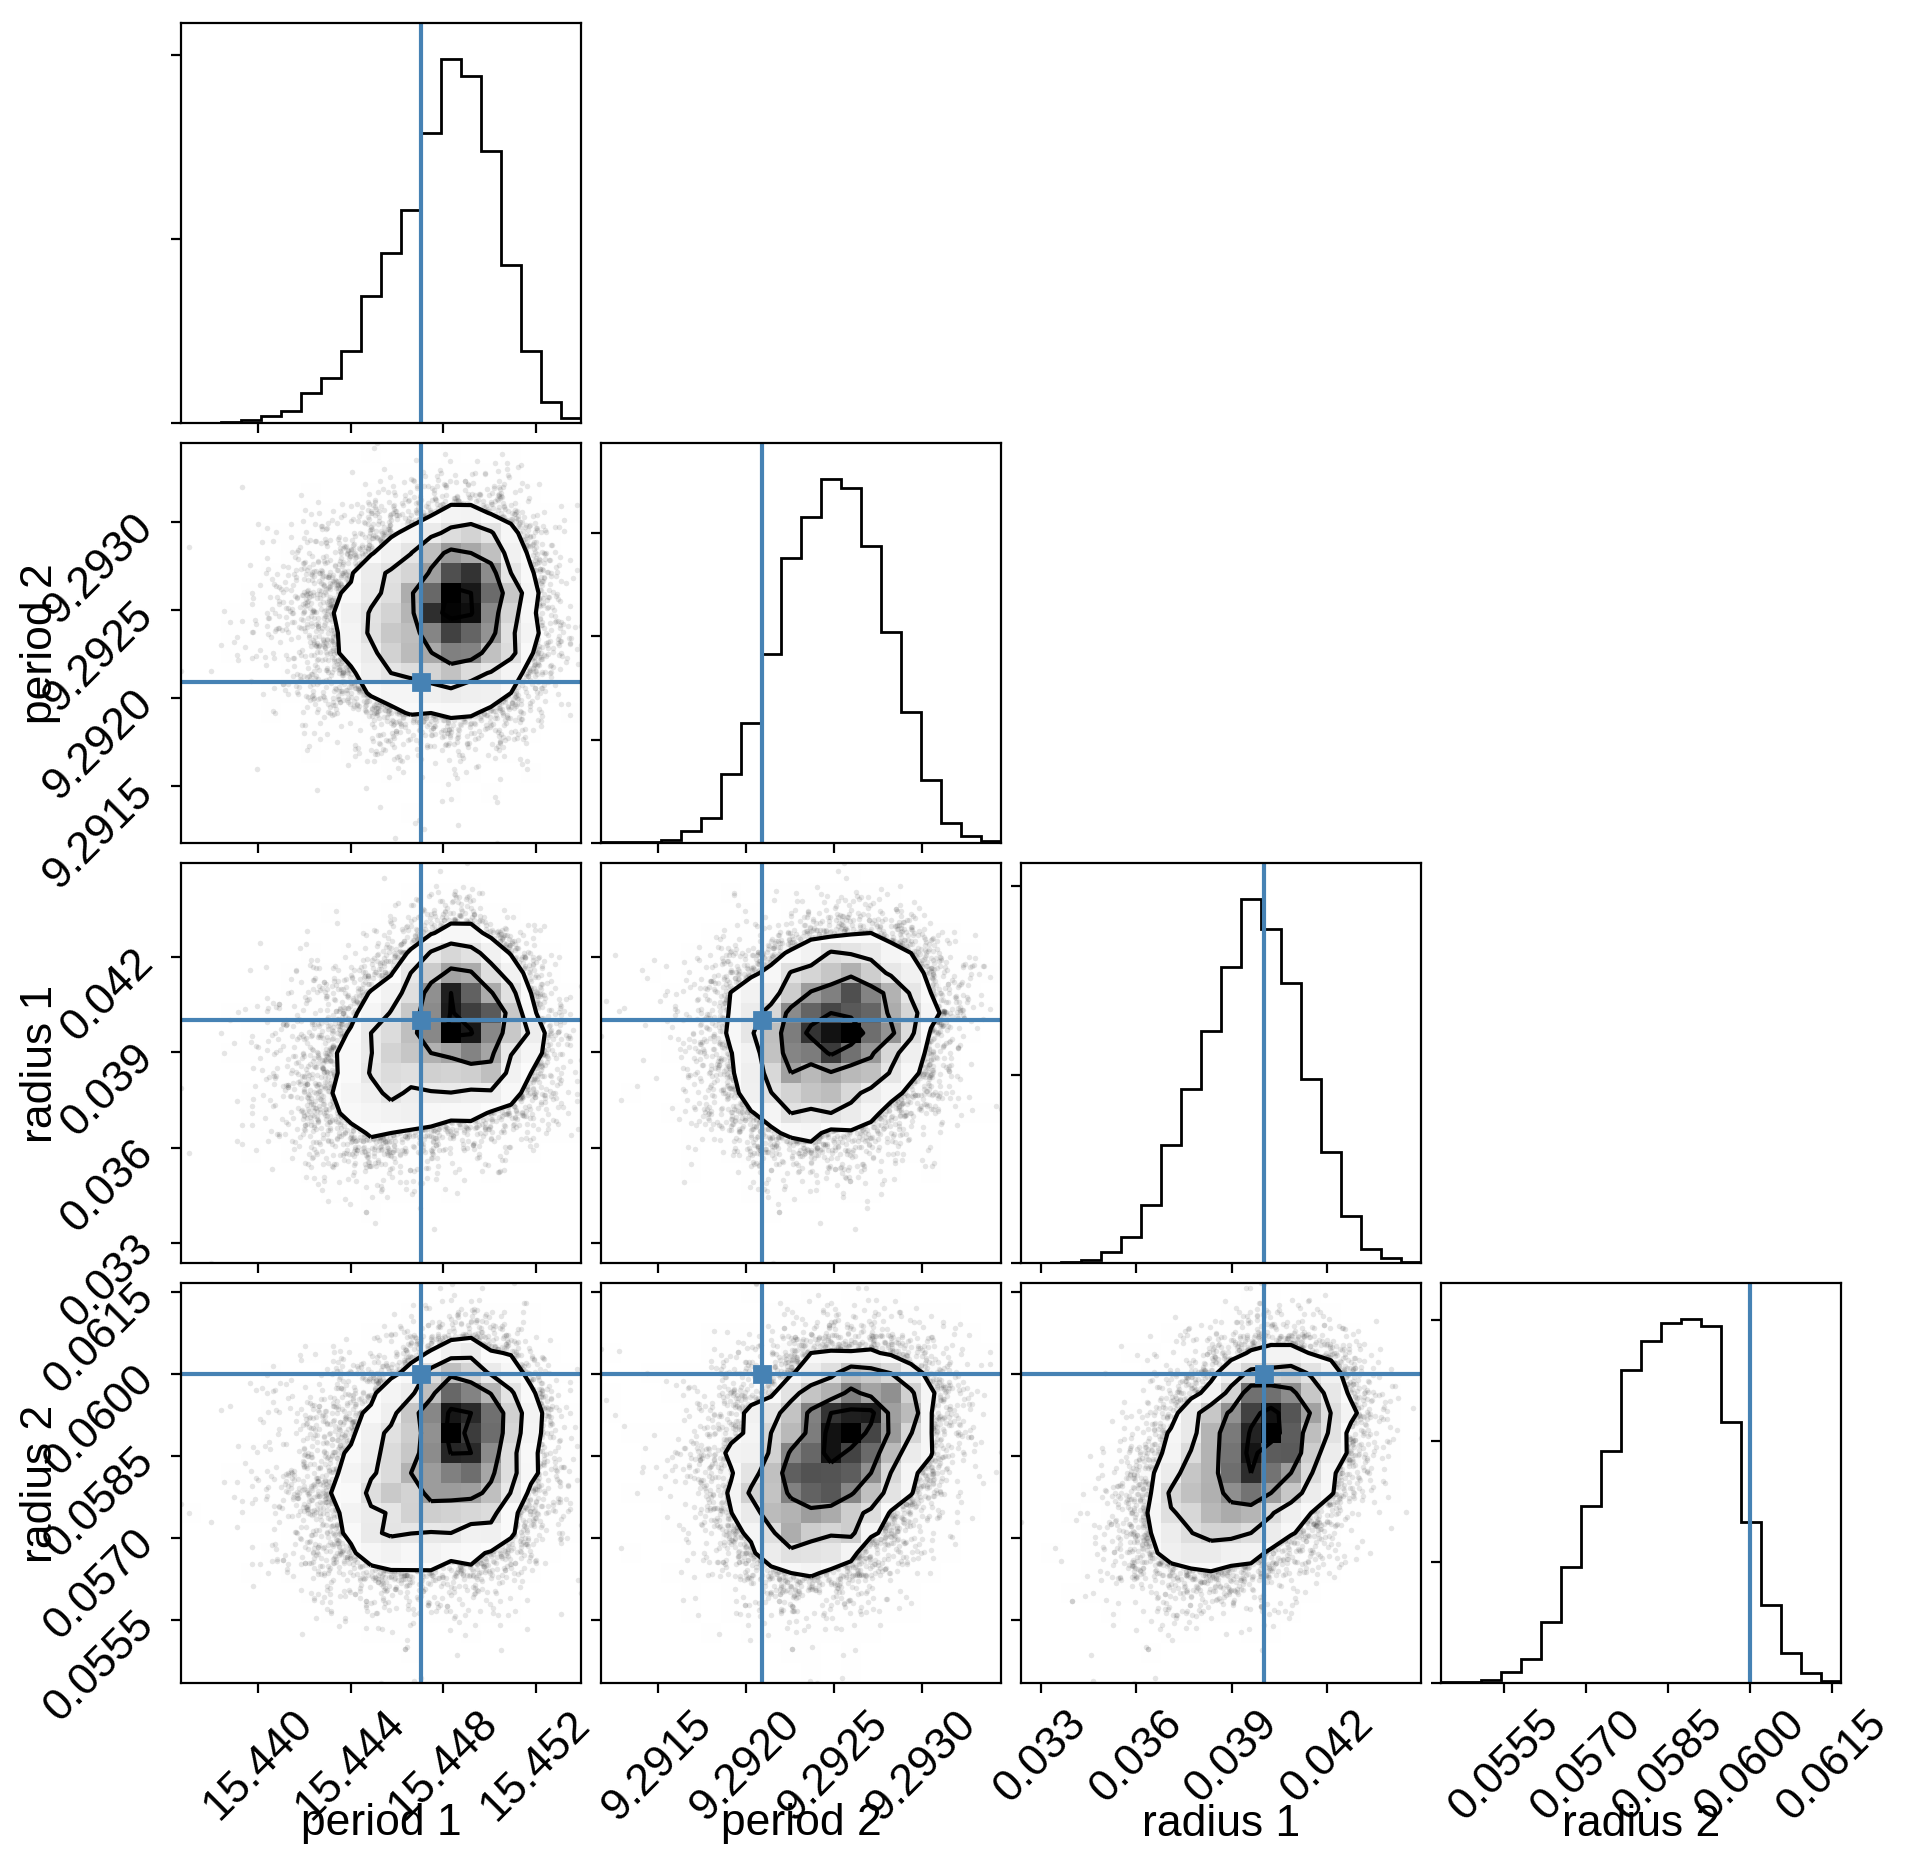

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

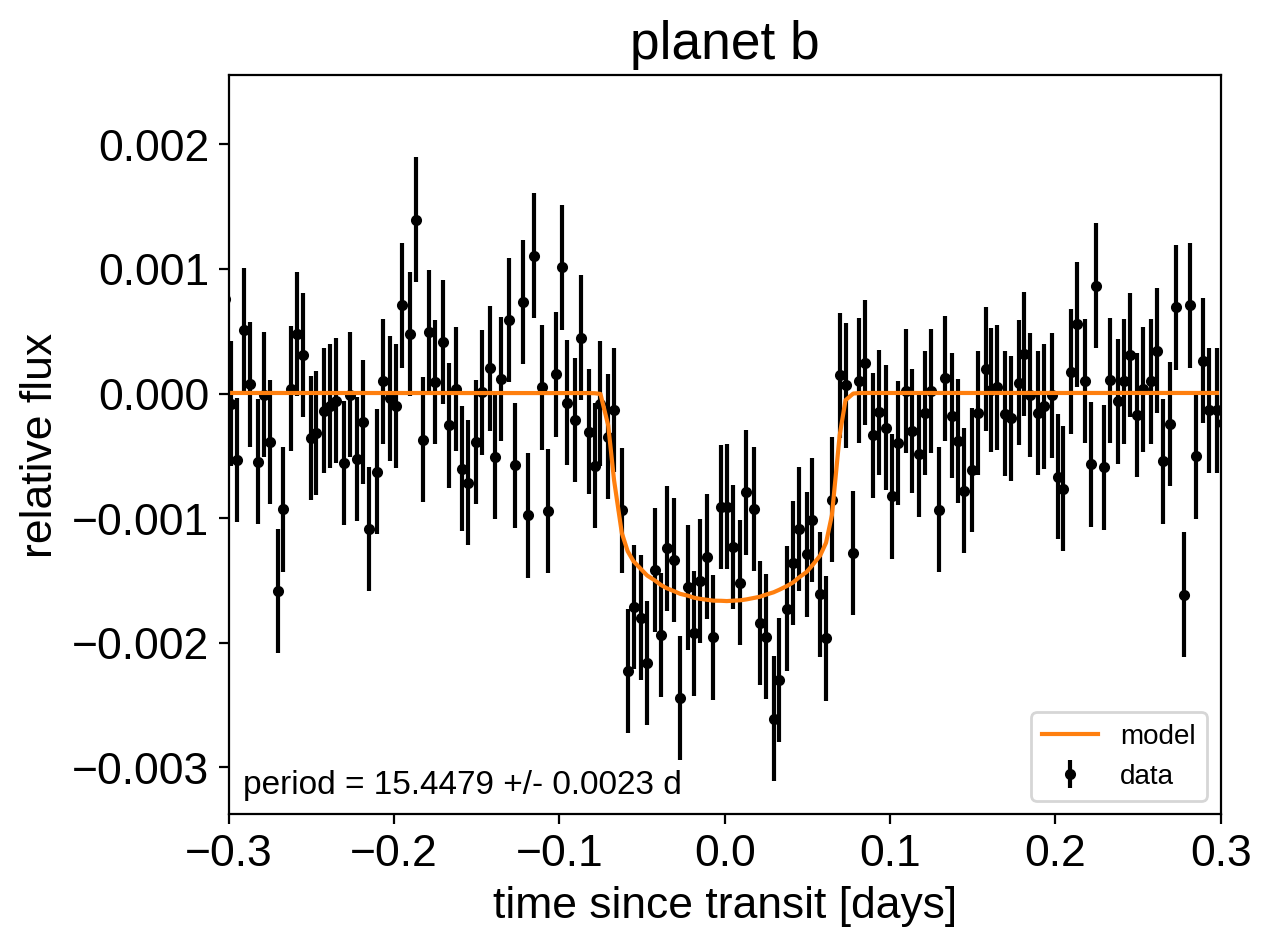

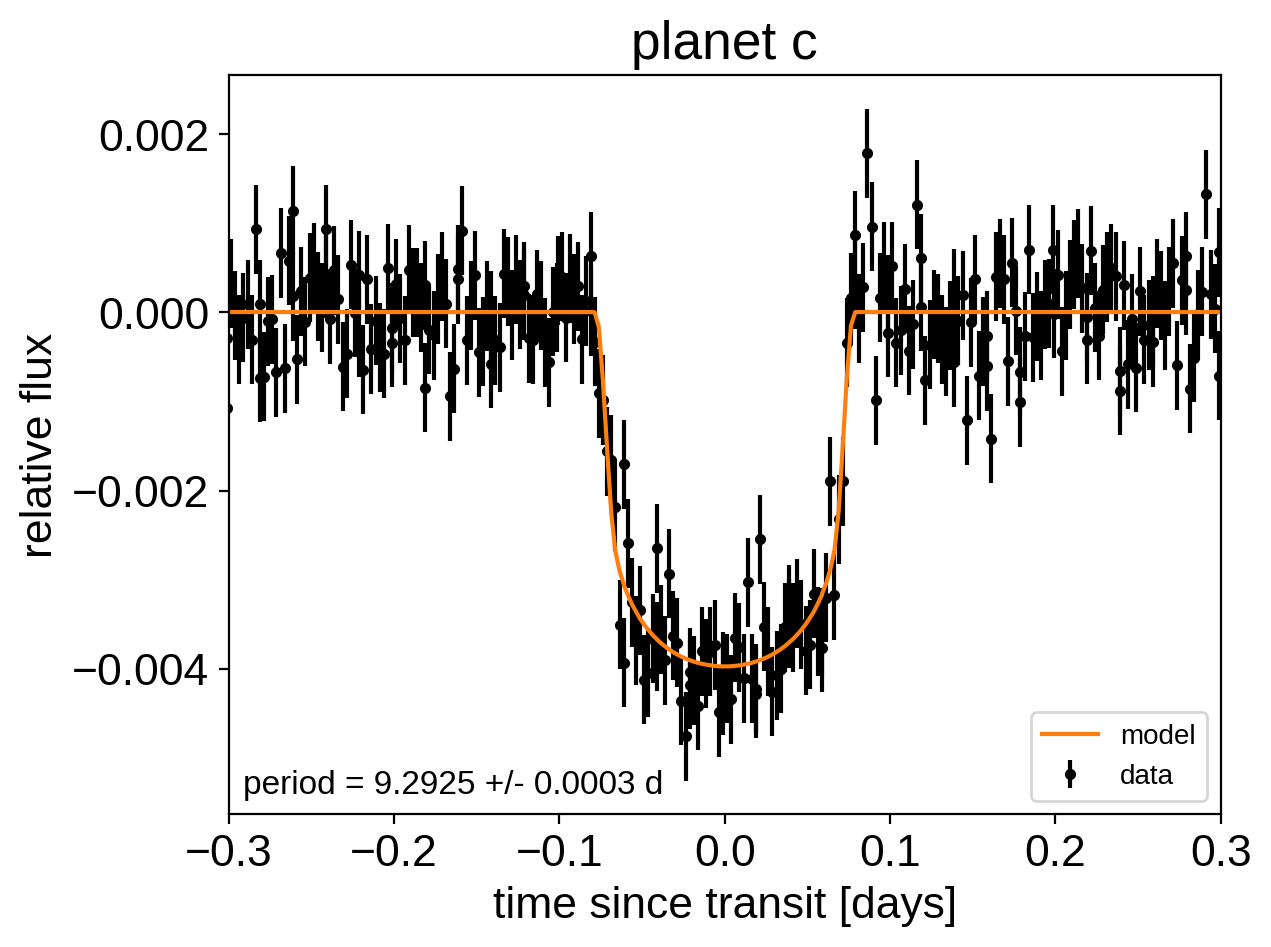

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
